# 第三章 Tensor

几乎所有的深度学习框架背后的设计核心都是张量和计算图，PyTorch也不例外，本章我们将学习PyTorch中的张量系统（Tensor）和自动微分系统（autograd）。

## 3.1 Tensor基础

Tensor，又名张量，读者可能对这个名词似曾相识，因为它不仅在PyTorch中出现过，它也是Theano、TensorFlow、Torch和MXNet中重要的数据结构。关于张量的本质不乏深度剖析的文章，但从工程角度讲，可简单地认为它就是一个数组，且支持高效的科学计算。它可以是一个数（标量）、一维数组（向量）、二维数组（矩阵）或更高维的数组（高阶数据）。Tensor和Numpy的ndarrays类似，但前者支持GPU加速。

本节将系统讲解Tensor的使用，力求面面俱到，但不会涉及每个函数。对于更多函数及其用法，读者可通过在IPython/Notebook中使用函数名加`?`查看帮助文档，或查阅PyTorch官方文档。

In [ ]:
# 查看PyTorch的版本号
import torch as t
t.__version__

### 3.1.1 Tensor 的基本操作

学习过NumPy的读者会对本节内容感到非常熟悉，因为Tensor的接口设计得与Numpy类似，以方便用户使用。当然，若读者不熟悉Numpy也没关系，本节内容并不要求读者事先掌握Numpy。

从接口的角度来讲，对Tensor的操作可分为两类：

1. `torch.function`，如`torch.save`等。
2. `tensor.function`，如`tensor.view`等。

为方便使用，对Tensor的大部分操作同时支持这两类接口，在本书中不做具体区分，如`torch.sum(a, b)`与`a.sum(b)`功能等价。

而从存储的角度来讲，对Tensor的操作又可分为两类：

1. 不会修改自身的数据，如 `a.add(b)`， 加法的结果会返回一个新的Tensor。
2. 会修改自身的数据，如 `a.add_(b)`， 加法的结果仍存储在a中，a被修改了。

函数名以`_`结尾的都是inplace方式，即会修改调用者自己的数据，在实际应用中需加以区分。

#### 创建Tensor

在PyTorch中创建Tensor的方法有很多，具体如表3-1所示：

表3-1: 常见创建Tensor的方法

|函数|功能|
|:---:|:---:|
|Tensor(\*sizes)|基础构造函数|
|tensor(data,)|类似np.array的构造函数|
|ones(\*sizes)|全1的Tensor|
|zeros(\*sizes)|全0的Tensor|
|eye(\*sizes)|对角线为1，其他为0|
|arange(s,e,step)|从s到e，步长为step|
|linspace(s,e,steps)|从s到e，均匀切分成steps份|
|rand / randn(\*sizes)|均匀/标准分布|
|normal(mean,std) / uniform(from,to)|正态分布/均匀分布|
|randperm(m)|随机排列|
|tensor.new_\* / torch.\*_like | 创建一个相同size大小，用*类型去填充（如tensor.new_ones就是使用全一的数据去填充）的张量，具有相同的torch.dtype和torch.device|

这些创建方法都可以在创建的时候指定数据类型dtype和存放device(CPU/GPU)。

使用`Tensor`函数新建Tensor可以接收一个list，并根据list的数据新建Tensor，同时也能根据指定的形状新建Tensor，还能传入其他的Tensor，下面将举几个例子说明。


In [ ]:
# 指定Tensor的形状
a = t.Tensor(2, 3)
a # 数值取决于内存空间的状态，print时候可能overflow

In [ ]:
# 用list的数据创建Tensor
b = t.Tensor([[1,2,3],[4,5,6]])
b

In [ ]:
b.tolist() # 把Tensor转为list

`tensor.size()`返回`torch.Size`对象，它是tuple的子类，但其使用方式与tuple略有区别。

In [ ]:
b_size = b.size()
b_size

In [ ]:
# 统计b中元素总个数，2*3，两种方式等价
b.numel(), b.nelement()

In [ ]:
# 创建一个和b形状一样的Tensor c
c = t.Tensor(b_size)
# 创建一个元素为2和3的Tensor d
d = t.Tensor((2, 3))
e = t.tensor([2,3])
c, d, e

需要注意的是，`t.Tensor(*sizes)`创建Tensor时，系统不会马上分配空间，只是会计算剩余的内存是否足够使用，在真正使用到Tensor时才会分配，而其它操作都是在创建完Tensor之后马上进行空间分配。在使用中，我们更推荐使用`torch.tensor`而非`torch.Tensor`。接下来比较一下两者的区别。

`torch.Tensor`是Python类，并且默认是torch.FloatTensor()，运行`torch.Tensor([2,3])`会直接调用Tensor类的构造函数`__init__()`，生成结果是单精度浮点类型的Tensor（FloatTensor）。
而`torch.tensor()`是一个Python函数，函数的原型为：`torch.tensor(data, dtype=None, device=None, requires_grad=False)`。其中`data`支持list、tuple、array、scalar等类型，`torch.tensor()`直接从`data`中做数据拷贝，并根据原数据类型生成相应的Tensor。

由于`torch.tensor()`能够根据数据类型生成对应的Tensor，因此在实际应用中我们更加推荐使用`torch.tensor()`方法来创建一个新的Tensor。下面将举例说明二者的不同之处。

In [ ]:
# torch.Tensor能直接创建空的张量
t.Tensor()

In [ ]:
# torch.tensor不能直接创建空的张量，需要传入一个空的data
# t.tensor() # TypeError: tensor() missing 1 required positional arguments: "data"
t.tensor(())

In [ ]:
a = t.tensor([2,3])
print(a.type())
b = t.Tensor([2,3])
print(b.type())

In [ ]:
import numpy as np
arr = np.ones((2, 3), dtype=np.float64)
a = t.tensor(arr)
a

其它常用的创建Tensor方法举例如下。

In [ ]:
# 创建一个形状是(2,3)值全为1的Tensor
t.ones(2, 3)

与`torch.ones()`类似的函数还有`torch.ones_like(input)`，输入`input`是一个Tensor，返回一个与之大小相同的全部填充为1的新Tensor。这意味着，`torch.ones_like(input)`等价于`torch.ones(input.size(), dtype=input.dtype, layout=input.layout, device=input.device)`。

In [ ]:
input_tensor = t.tensor([[1, 2, 3], [4, 5, 6]])
t.ones_like(input_tensor)

In [ ]:
# 创建一个形状是(2,3)的全0的Tensor
t.zeros(2, 3)

In [ ]:
# 创建一个对角线为1，其余为0的Tensor,不要求行列数一致
t.eye(2, 3, dtype=t.int)

In [ ]:
# 创建一个起始值为1，上限为6，步长为2的Tensor
t.arange(1, 6, 2)

In [ ]:
# 创建一个均匀间距的Tensor，将1到10的数分为3份
t.linspace(1, 10, 3)

In [ ]:
# 创建一个形状是(2,3)的Tensor，其取值为从标准正态分布中抽取的随机数
t.randn(2, 3)

In [ ]:
# 创建一个长度为5的随机排列的Tensor
t.randperm(5) 

In [ ]:
# 创建一个大小为(2，3)值全1的Tensor，保留原始的torch.dtype和torch.device
tensor3 = t.tensor((), dtype=t.int32)
tensor3.new_ones((2, 3))

#### 命名张量

命名张量（Named Tensors）旨在允许用户将显式名称与张量维度关联起来，使张量更易于使用。在大多数情况下，使用维度名称来进行维度操作，从而避免了按位置确定维度的需要。此外，命名张量使用名称来自动检查API是否在运行时正确使用，从而提供额外的安全性。名称还可用于重新排列维度，例如，支持“按名称广播”而不是“按位置广播”等等。现在允许张量拥有命名维度的工厂函数（factory functions）有：tensor，empty，ones，zeros，randn等等。

下面将以深度学习中常用的维度来举例说明命名张量的使用，其中`N`代表batch_size，`C`代表通道数，`H`代表高度，`W`代表宽度。

In [ ]:
# 命名张量API在后续还有可能还有变化，所以会系统会提示warning，在此忽略
import warnings
warnings.filterwarnings("ignore")
# 直接使用names参数创建命名张量
imgs = t.randn(1, 2, 2, 3, names=('N', 'C', 'H', 'W'))
imgs.names

In [ ]:
# 查看旋转操作造成的维度变换
imgs_rotate = imgs.transpose(2, 3) # 将张量的第2个和第3个维度进行交换
imgs_rotate.names

In [ ]:
# 通过refine_names()函数对未命名的张量命名，其中不需要名字的可以用None表示
another_imgs = t.rand(1, 3, 2, 2)
another_imgs = another_imgs.refine_names('N', None, 'H', 'W')
another_imgs.names

In [ ]:
# 修改部分维度的名称
renamed_imgs = imgs.rename(H='height', W='width')
renamed_imgs.names

In [ ]:
# 通过维度的名称做维度转换
convert_imgs = renamed_imgs.align_to('N', 'height', 'width', 'C')
convert_imgs.names

命名张量还可以直观的用于说明Tensor的形状改变和维度增减，这一部分将在3.2节进行详细介绍。

#### Tensor的类型

 Tensor有不同的数据类型，如表3-2所示，每种类型分别对应有CPU和GPU版本(HalfTensor除外)。默认的Tensor是FloatTensor，可通过`torch.set_default_tensor_type` 来修改默认Tensor类型(如果默认类型为GPU tensor，则所有操作都将在GPU上进行)。Tensor的类型对分析内存占用很有帮助。例如，一个size为(1000, 1000, 1000)的FloatTensor，它有`1000*1000*1000=10^9`个元素，每个元素占32bit/8 = 4Byte内存，所以共占大约4GB内存/显存。HalfTensor是专门为GPU版本设计的，同样的元素个数，显存占用只有FloatTensor的一半，所以可以极大缓解GPU显存不足的问题，但由于HalfTensor所能表示的数值大小和精度有限，所以可能出现溢出等问题。


表3-2: Tensor数据类型

| Data type | dtype | CPU tensor   | GPU tensor   |
| ------------------------ | --------------------------------- | ----------------------------------------- | ------------------------- |
| 32-bit 浮点型   | `torch.float32` or `torch.float`  | `torch.FloatTensor`  | `torch.cuda.FloatTensor`  |
| 64-bit 浮点型   | `torch.float64` or `torch.double` | `torch.DoubleTensor` | `torch.cuda.DoubleTensor` |
| 16-bit 半精度浮点型    | `torch.float16` or `torch.half`  | `torch.HalfTensor`| `torch.cuda.HalfTensor`|
| 8-bit无符号整型 | `torch.uint8`  | `torch.ByteTensor`| `torch.cuda.ByteTensor`|
| 8-bit有符号整型  | `torch.int8`  | `torch.CharTensor`| `torch.cuda.CharTensor`|
| 16-bit有符号整型  | `torch.int16` or `torch.short`   | `torch.ShortTensor` | `torch.cuda.ShortTensor`  |
| 32-bit有符号整型 | `torch.int32` or `torch.int`  | `torch.IntTensor` | `torch.cuda.IntTensor` |
| 64-bit有符号整型  | `torch.int64` or `torch.long`  | `torch.LongTensor` | `torch.cuda.LongTensor`|


不同Tensor类型之间是可以互相转换的，下面是常用的三种转换方法：

1. 各种数据类型之间可以互相转换，`type(new_type)`是通用的做法，同时还有`float`、`long`、`half`等快捷方法；
2. CPU Tensor与GPU Tensor之间的互相转换通过`tensor.cuda`和`tensor.cpu`方法实现，此外还可以使用`tensor.to(device)`；
3. 创建同种类型的张量:`torch.*_like` 和 `tensor.new_*`。Tensor还有一个`new`方法，用法与`torch.Tensor`一样，会调用该Tensor对应类型的构造函数，生成与当前Tensor类型一致的Tensor。如`torch.*_like(tensorA)` 可以生成和`tensorA`拥有同样属性(类型，形状，CPU/GPU)的新Tensor，例如`torch.ones_like()`，而`tensor.new_*(new_shape)` 可以新建一个不同形状的Tensor，例如`tensor.new_zeros()`。

下面将举例说明Tensor之间的转换：

In [ ]:
# 更改默认Tensor的类型
a = t.rand(2, 3)
print(a.dtype)
# 设置默认类型为DoubleTensor
t.set_default_tensor_type('torch.DoubleTensor')
a = t.rand(2, 3)
print(a.dtype)
# 恢复之前的默认设置
t.set_default_tensor_type('torch.FloatTensor')

In [ ]:
# 通过type方法和快捷方法修改Tensor的类型
b1 = a.type(t.FloatTensor)
b2 = a.float()
a.dtype, b1.dtype, b2.dtype

In [ ]:
# new方法相当于利用DoubleTensor的构造函数，因为此时a是torch.float64类型
a.new(2,3)

#### 索引操作

Tensor支持与numpy.ndarray类似的索引操作，语法上也类似，下面将通过一些例子讲解常用的索引操作。其中，能通过修改张量stride/start/dim等属性实现的索引操作与原Tensor共享内存，也就是说如果修改其中一个，另一个会跟着修改。关于索引操作更详细的内容将在本书第六章中进行讲解。

In [ ]:
a = t.randn(3, 4)
a

In [ ]:
print("查看第1行结果：", a[0])
print("查看第2列结果：", a[:,1])
print("查看第2行最后两个元素：", a[1, -2:])

In [ ]:
# 返回一个ByteTensor
print(a > 0) # bool型
print((a > 0).int()) # 整型

In [ ]:
# 返回Tensor中满足条件的结果，下面两种写法等价
# 选择返回的结果与原Tensor不共享内存空间
print(a[a > 0])
print(a.masked_select(a>0)) 
# 用torch.where保留原始的索引位置，不满足条件的位置置0
print(t.where(a > 0, a, t.zeros_like(a)))

其它常用的选择函数如表3-3所示。

表3-3常用的选择函数

函数|功能|
:---:|:---:|
index_select(input, dim, index)|在指定维度dim上选取，比如选取某些行、某些列
masked_select(input, mask)|例子如上，a[a>0]，使用ByteTensor进行选取
non_zero(input)|非0元素的下标
gather(input, dim, index)|根据index，在dim维度上选取数据，输出的size与index一样


`gather`是一个比较复杂的操作，对一个2维Tensor，输出的每个元素如下：

```python
out[i][j] = input[index[i][j]][j]  # dim=0
out[i][j] = input[i][index[i][j]]  # dim=1
```

In [ ]:
a = t.arange(0, 16).view(4, 4)
a

In [ ]:
# 选取对角线的元素
index = t.tensor([[0,1,2,3]])
a.gather(0, index)

In [ ]:
# 选取反对角线上的元素
index = t.tensor([[3,2,1,0]]).t()
a.gather(1, index)

In [ ]:
# 选取两个对角线上的元素
index = t.tensor([[0,1,2,3],[3,2,1,0]]).t()
print(a)
b = a.gather(1, index)
b

与`gather`相对应的逆操作是`scatter_`，`gather`把数据从input中按index取出，而`scatter_`是把取出的数据再放回去。注意`scatter_`函数是inplace操作，会直接对当前数据进行修改。

```python
out = input.gather(dim, index)
-->近似逆操作
out = Tensor()
out.scatter_(dim, index)
```

In [ ]:
# 把两个对角线元素放回去到指定位置
c = t.zeros(4,4).long()
c.scatter_(1, index, b)

对Tensor的任何索引操作得到的结果仍是一个Tensor，若想要获取标准的Python对象数值，需要调用`tensor.item()`，需要注意的是这个方法只对包含一个元素的Tensor适用。

In [ ]:
t.Tensor([1.]).item()
# t.Tensor([1, 2]).item()  ->
# raise ValueError: only one element tensors can be converted to Python scalars

#### 高级索引

目前的PyTorch已经支持绝大多数NumPy风格的高级索引。高级索引可以看成是普通索引操作的扩展，但是高级索引操作的结果一般不和原始的Tensor共享内存。关于更多高级索引的内容可以参考本书第六章第三节。

In [ ]:
x = t.arange(0,16).view(2,2,4)
x

In [ ]:
x[[1, 0], [1, 1], [2, 0]] # x[1,1,2]和x[0,1,0]

In [ ]:
x[[1, 0], [0], [1]] # x[1,0,1],x[0,0,1]

#### 逐元素操作

逐元素操作会对Tensor的每一个元素(point-wise，又名element-wise)进行操作，此类操作的输入与输出形状一致。常用的操作如表3-4所示。

表3-4: 常见的逐元素操作

|函数|功能|
|:--:|:--:|
|abs/sqrt/div/exp/fmod/log/pow..|绝对值/平方根/除法/指数/求余/对数/求幂..|
|cos/sin/asin/atan2/cosh..|三角函数|
|ceil/round/floor/trunc| 上取整/四舍五入/下取整/只保留整数部分|
|clamp(input,min,max)|超过min和max部分截断|
|sigmod/tanh..|激活函数

对于很多操作，例如div、mul、pow、fmod等，PyTorch中都实现了运算符重载，因此读者可以很方便的直接使用。如`a ** 2` 等价于`torch.pow(a,2)`, `a * 2`等价于`torch.mul(a,2)`。

其中`clamp(x, min, max)`的输出满足以下公式：
$$
y_i =
\begin{cases}
min,  & \text{if  } x_i \lt min \\
x_i,  & \text{if  } min \le x_i \le max  \\
max,  & \text{if  } x_i \gt max\\
\end{cases}
$$
`clamp`常用在某些需要比较大小的地方，如取一个Tensor的每个元素与另一个数的较大值。下面将举例说明一些常见的逐元素操作：

In [ ]:
a = t.arange(0, 6).float().view(2, 3)
print(t.cos(a))
print(a)

In [ ]:
# 取模运算的运算符重载，二者等价
print(a % 3)
print(t.fmod(a, 3))

In [ ]:
# 将a中的值进行上下限截断
print(a)
print(t.clamp(a, min=2, max=4))

####  归并操作 

归并操作会使用Tensor中的部分元素进行计算，其输出形状可能小于输入形状。同时我们可以沿着某一维度进行指定的归并操作。如加法`sum`，既可以计算整个Tensor的和，也可以计算Tensor中每一行或每一列的和。常用的归并操作如表3-5所示。

表3-5: 常用归并操作

|函数|功能|
|:---:|:---:|
|mean/sum/median/mode|均值/求和/中位数/众数|
|norm/dist|范数/距离|
|std/var|标准差/方差|
|cumsum/cumprod|累加/累乘|

以上大多数函数都有一个维度参数`dim`，用来指定这些操作是在哪个维度上执行的。关于`dim`(对应于Numpy中的axis)的解释众说纷纭，这里提供一个简单的记忆方式：

假设输入的形状是(m, n, k)

- 如果指定dim=0，输出的形状就是(1, n, k)或者(n, k)
- 如果指定dim=1，输出的形状就是(m, 1, k)或者(m, k)
- 如果指定dim=2，输出的形状就是(m, n, 1)或者(m, n)

其中size中是否有"1"，取决于参数`keepdim`，若指定`keepdim=True`则会保留维度`1`。注意，以上只是经验总结，并非所有函数都符合这种形状变化方式，如`cumsum`。下面将举例说明：

In [ ]:
# 注意对比是否保留维度1的区别
b = t.ones(2, 3)
print(b.sum(dim=0, keepdim=True ),b.sum(dim=0, keepdim=True ).shape)
print(b.sum(dim=0, keepdim=False), b.sum(dim=0, keepdim=False).shape)

In [ ]:
a = t.arange(2, 8).view(2, 3)
print(a)
print(a.cumsum(dim=1)) # 沿着行 累 加

#### 比较

比较函数中有一些是逐元素比较，操作类似于逐元素操作，还有一些则类似于归并操作。常用比较函数如表3-6所示。

表3-6: 常用比较函数

|函数|功能|
|:--:|:--:|
|gt/lt/ge/le/eq/ne|大于/小于/大于等于/小于等于/等于/不等于|
|topk|最大的k个数|
|sort|排序|
|max/min|比较两个Tensor的最大、最小值|

表中第一行的比较操作已经实现了运算符重载，因此可以使用`a>=b`、`a>b`、`a!=b`、`a==b`，其返回结果是一个`ByteTensor`，可用来选取元素。max/min这两个操作比较特殊，以max来说，它有以下三种使用情况：
- t.max(tensor)：返回Tensor中最大的一个数
- t.max(tensor,dim)：指定维上最大的数，返回Tensor和下标
- t.max(tensor1, tensor2): 返回两个Tensor相比较大的元素

而若要比较一个Tensor和一个数，可以使用clamp函数。下面举例说明。

In [ ]:
a = t.linspace(0, 15, 6).view(2, 3)
b = t.linspace(15, 0, 6).view(2, 3)

print(a > b) # 返回布尔类型

print("a中大于b的元素: ", a[a > b]) # 返回a中大于b的元素
print("a中最大的元素: ", t.max(a)) # 返回a中最大的元素

In [ ]:
print(b)
t.max(b, dim=1) # 按照第一维比较
# 第一个返回值15和6分别表示第0行和第1行最大的元素
# 第二个返回值的0和0表示上述最大的数是该行第0个元素

In [ ]:
t.max(a, b) # 两个Tensor对应位置上较大的元素

#### 线性代数

PyTorch的线性函数主要封装了Blas和Lapack，其用法和接口都与之类似。常用的线性代数函数如表3-7所示。

表3-7: 常用的线性代数函数

|函数|功能|
|:---:|:---:|
|trace|对角线元素之和(矩阵的迹)|
|diag|对角线元素|
|triu/tril|矩阵的上三角/下三角，可指定偏移量|
|mm/bmm|矩阵乘法，batch的矩阵乘法|
|addmm/addbmm/addmv|矩阵运算
|t|转置|
|dot/cross|内积/外积
|inverse|求逆矩阵
|svd|奇异值分解

具体使用说明请参见官方文档，需要注意的是，矩阵的转置会导致存储空间不连续，因此需调用它的`.contiguous`方法将其转为连续。下面将举例说明：


In [ ]:
a = t.linspace(0, 15, 6).view(2, 3)
b = a.t()
b.is_contiguous()

In [ ]:
b = b.contiguous()
b.is_contiguous()

### 3.1.2 Tensor与NumPy

Tensor和NumPy数组之间具有很高的相似性，彼此之间的互相操作也非常简单高效。需要注意的是，NumPy和Tensor共享内存。由于NumPy中已经封装了很多常用操作，所以当遇到Tensor不支持的操作时，可先将其转换成NumPy数组，进行相应处理后再转回Tensor。由于这样操作的转换开销很小，因此在实际应用中我们将经常进行两者的相互转换，下面将举例说明。

In [ ]:
import numpy as np
a = np.ones([2, 3],dtype=np.float32)
a

In [ ]:
# 从NumPy转化为Tensor，下面两种方式等价
b = t.from_numpy(a)
# 注意此时是大写的Tensor，torch.Tensor()只进行数据拷贝，不会共享内存。
# b = t.Tensor(a)
b

In [ ]:
# 此时，NumPy和Tensor是共享内存的
a[0, 1] = -1
b # 修改a的值，b的值也会被修改

**注意**： 当NumPy的数据类型和Tensor的类型不一样的时候，数据会被复制，不会共享内存。

In [ ]:
a = np.ones([2, 3])
# 注意和上面的a的区别（dtype不是float32）
print(a.dtype)
a

In [ ]:
b = t.Tensor(a) # 此处进行拷贝，不共享内存
b.dtype

In [ ]:
c = t.from_numpy(a) # 注意c的类型（DoubleTensor）
c

In [ ]:
a[0, 1] = -1
print(b) # b与a不共享内存，所以即使a改变了，b也不变
print(c) # c与a共享内存

**注意：** 不论输入的类型是什么，torch.tensor()都只进行进行数据拷贝，不会共享内存。读者需要注意区分torch.Tensor(),torch.from_numpy()与torch.tensor()在内存共享方面的区别。

In [ ]:
a_tensor = t.tensor(a)
a_tensor[0, 1] = 1
a # a和a_tensor不共享内存

### 3.1.3 Tensor的基本结构

Tensor的数据结构如图3-1所示。Tensor分为头信息区(Tensor)和存储区(Storage)，信息区主要保存着Tensor的形状（size）、步长（stride）、数据类型（type）等信息，而真正的数据则保存成连续数组。由于数据动辄成千上万，因此信息区元素占用内存较少，主要内存占用取决于Tensor中元素的数目，也即存储区的大小。

一般来说一个Tensor有与之对应的Storage，Storage是在data之上封装的接口，便于使用，而Tensor的内存地址是指向Tensor的头（head）。不同Tensor的head信息一般不同，但却可能使用相同的Storage。很多关于Tensor的操作只是创建了一个新的head，但是它们仍共享同一个Storage，下面将举例说明。

![图3-1: Tensor的数据结构](imgs/tensor_data_structure.png)

In [ ]:
a = t.arange(0, 6).float()
b = a.view(2, 3)
# id(变量)可以查看它在内存中的地址
# Storage的内存地址一样，即它们是同一个Storage
print(id(b.untyped_storage()) == id(a.untyped_storage()))

print(a)

In [ ]:
# a改变，b也随之改变，因为他们共享Storage
a[1] = 100
b

In [ ]:
# c取得a的部分索引，只改变了head信息，Storage相同
c = a[2:] 
print(c)
id(c.untyped_storage()) == id(a.untyped_storage())

In [ ]:
c.data_ptr(), a.data_ptr() # data_ptr返回Tensor首元素的内存地址
# 可以看出两个内存地址相差8，这是因为2*4=8：相差两个元素，每个元素占4个字节(float)
# 如果差值不是8（如16），可以用a.type()查看一下数据类型是不是torch.FloatTensor

In [ ]:
c[0] = -100 # c[0]的内存地址对应a[2]的内存地址
a

In [ ]:
d = t.Tensor(c.storage()) # 此处拷贝共享了内存
d[0] = 6666
b

In [ ]:
# 下面４个Tensor共享Storage
id(a.untyped_storage()) == id(b.untyped_storage()) == id(c.untyped_storage()) == id(d.untyped_storage())

In [ ]:
# c取得a的部分索引，改变了偏移量
a.storage_offset(), c.storage_offset(), d.storage_offset()

In [ ]:
e = b[::2, ::2] # 隔2行/列取一个元素
print(id(e.storage()) == id(a.storage())) # 共享内存
print(e.is_contiguous()) # e的存储空间是不连续的

可见绝大多数操作并不修改Tensor的数据，而只是修改了Tensor的头信息。这种做法更节省内存，同时提升了处理速度。在使用中需要注意：有些操作会导致Tensor不连续，这时需要调用`tensor.contiguous`方法将它们变成连续的数据，该方法会使数据复制一份，不再与原来的数据共享Storage。
另外读者可以思考一下，之前说过的高级索引一般不共享Storage，而普通索引则共享Storage，这是为什么？（提示：普通索引可以通过修改Tensor的offset、stride和size实现，不修改Storage的数据，高级索引则不行）。

## 3.2 变形记：N种改变Tensor形状的方法

Tensor作为PyTorch的基本数据对象，使用过程中常需要改变Tensor的形状。在PyTorch中有很多用于改变形状的函数，在这一小节中我们将详细介绍一些常用的方法。

本小节介绍的所有函数都可以用`tensor.shape` 和`tensor.reshape(*new_shape)`来实现，这里笔者将对常见的Tensor形状相关的操作进行总结，以方便读者选择最灵活便捷的函数。


### 查看Tensor的维度

关于Tensor的形状信息，除了`tensor.shape`， 还有以下三个常用函数：
- `tensor.size()` 等价于`tensor.shape`；
- `tensor.dim()` 能查看Tensor的维度，等效于`len(tensor.shape)`,对应于NumPy中的`array.ndim`；
- `tensor.numel()` 用来查看tensor中元素的数量，等价于`tensor.shape[0]*tensor.shape[1]*...`或者`np.prod(tensor.shape)`, 对应于NumPy中的`array.size`。

In [ ]:
import torch as t
tensor = t.arange(24).reshape(2, 3, 4)
# tensor.shape 和tensor.size() 等价
print(f"a.shape={tensor.shape}. a.size()={tensor.size()}")

print(tensor)

In [ ]:
f'这是个{tensor.dim()}维Tensor, 总共{tensor.numel()}个元素'

### 改变Tensor的维度
所有改变Tensor形状的操作都可以通过`tensor.reshape`实现。`tensor.reshape(new_shape)`会把不连续的Tensor变成连续的再进行形状变化，这一操作等价于`tensor.contiguous().view(new_shape)`。关于`view`和`reshape`的选用可参考下面的建议:

1. 对于`reshape`而言:其接口更便捷，会自动把不连续的Tensor变为连续的，能避免很多报错。同时它的函数名和NumPy一样，便于使用。
2. 对于`view`而言:其函数名更短，而且Tensor经过`view`操作之后仍然共享存储空间。当我们并不希望改变形状之后的Tensor和原Tensor共享存储时可以使用`view`方法。

`reshape`和`view`二者之间有一些区别：如果对Tensor使用了`transpose`、`permute`等操作，会造成Tensor的内存变得不连续，而`view`方法只能改变连续的张量，所以需要先调用`contiguous()`方法，但`reshape`方法则不受此限制。具体来说，`view`方法返回的Tensor和原Tensor共享Storage（注意：不是共享内存地址），而`reshape`方法可能返回原Tensor的copy或者共享Storage的view。如果当前满足连续性条件，则结果与`view`相同；否则返回的就是copy（此时等价于`tensor.contiguous().view()`）。

In [ ]:
a = t.arange(1, 13)
b = a.view(2, 6)
c = a.reshape(2, 6) # 此时view和reshape等价，因为Tensor是contiguous
# a,b,c三个对象的内存地址是不一样的，其中保存的是Tensor的形状(size)、步长(stride)、数据类型(type)等信息
id(a)==id(b)==id(c)

In [ ]:
# view和reshape存储在与原始对象不同的地址内存中，但是它们共享存储器Storage，也就意味着它们共享基础数据
id(a.untyped_storage())==id(b.untyped_storage())==id(c.untyped_storage())

In [ ]:
b = b.t() # b 不再连续
b.reshape(-1, 4) # reshape 可以

# 下面会报错，view无法在改变数据存储的情况下进行形状变化
# b.view(-1, 4)

reshape操作的难点在于如何快速灵活地指定形状，常用的快捷变形方法有：

1. `tensor.view(dim1,-1,dimN)`: 在调整Tensor形状的时候，我们不需要指定每一维的形状，可以把其中一个维度指定为-1，PyTorch会自动计算对应的形状
2. `tensor.view_as(other)`: 将Tensor的形状变为和other 一样，等价于`tensor.view(other.shape)`
3. `tensor.squeeze()`: 将Tensor形状中为`1`的维度去掉，比如(1,3,1,4)变为(3,4)
4. `tensor.flatten(start_dim=0, end_dim=-1)`: 将Tensor形状中某些连续维度合并为一个维度. 比如形状(2,3,4,5) ->(2,12,5)。
5. `tensor[None]` 和`tensor.unsqueeze(dim)`: 为Tensor新建一个维度，并把形状设为1, 比如形状(2,3) -> (2,1,3)

In [ ]:
# 创建一张噪声图像, 并计算RGB每一个通道的噪声均值
img_3xHxW = t.randn(3,128,256) 

# 将img_3xHxW的后两维合并
img_3xHW = img_3xHxW.view(3, -1)
# 写法等价于img_3xHxW.view(3,128*256)
# 也等价于img_3xHxW.flatten(1,2)
img_3xHW.mean(dim=1)   # 沿着维度1求平均值，剩下 3*1 形状的张量

In [ ]:
# 图片除了RGB通道，还可以有alpha通道用来表示透明度
alpha_HxW = t.rand(128,256)
# alpha_1xHxW = alpha_HxW[None] # 等价于 alpha.unsqueeze(0)
alpha_1xHxW = alpha_HxW.unsqueeze(dim=0)

rgba_img = t.cat([alpha_1xHxW, img_3xHxW], dim=0)  # 沿着第0维拼接，第0维直接相加即可
rgba_img.shape 

In [ ]:
# 去掉第一维的1
# 也可以使用alpha_1xHxW.squeeze()：去掉所有为1的维度
# 也可以使用alpha_1xHxW.flatten(0,1): 1和128合并
# 也可以使用alpha_1xHxW[0]： 通过索引取出第一维的数据
alpha_HxW = alpha_1xHxW.view(128, 256)

### 转置`torch.transpose/tensor.permute`

注意，Tensor的转置（transpose）和改变形状（reshape）是两个不一样的概念。比如将一张图片旋转90度，就属于向量的转置，无法通过单纯的改变向量形状实现。

`transpose`和`permute`函数都可以用于高维矩阵的转置，但用法上稍有区别：`transpose`只能用于两个维度的转置，意思就是只能改变两个维度的信息，而`permute`可以对任意高维矩阵进行转置，直接输入转置后维度index即可。我们可以通过多次`transpose`变换达到和`permute`相同的效果。常用的转置操作还有`tensor.t()`和`tensor.T`，它们和`tensor.transpose()`一样都属于`permute`的特例。

另外，向量的转置操作大多数情况下和输入的Tensor共享存储，但是会使得向量变得不连续, 此时最好通过`tensor.contiguous()`将它变成连续。但是有些操作(比如`tensor.sum/max`)支持不连续的Tensor，那么你可以不用将它变成连续, 这样可以节省内存/显存。

In [ ]:
mask = t.arange(6).view(2,3) # 一张高为2，宽为3的图片
mask

In [ ]:
# 将图片旋转90度, 也就是第一个维度(0)和第二个维度交换
# 等价于mask.transpose(1,0)
# 等价于mask.t() 或 img.T
# 等价于mask.permute(1,0), 不等价于img.permute(0,1)
mask.transpose(0,1)

In [ ]:
# 单纯地改变图片的形状
# 注意和上面的区别，结果仍然是连续的
mask.view(3,2)

In [ ]:
# PyTorch等深度学习框架中图片一般存储为3xHxW
img_3xHxW = t.randn(3,128,256) 

# 而在OpenCV/NumPy/skimage 中，图片一般存储为HxWx3
# img_3xHxW的形状为shape=[3,H,W],经过permute(1,2,0)得到的形状为:
# [shape[1], shape[2], shape[0]] = [H, W, 3]

# permute 其实就是重新排列了Tensor的维度
img_HxWx3 = img_3xHxW.permute(1,2,0)

img_HxWx3.is_contiguous()

In [ ]:
img_HxWx3.reshape(-1) # .view 会报错，因为img_HxWx3不连续   
# 变成了1维的向量，通常用来flatten

一个用来区分什么时候用`tensor.reshape`还是`tensor.transpose`的小技巧：如果输出Tensor的数据排列和输入一样就是用`tensor.reshape`，否则应该使用`tensor.transpose`。

In [ ]:
H, W = 4, 5
img_3xHxW = t.randn(3, H, W)

# 目标数据排列和输入一样，直接使用reshape
img_3xHW = img_3xHxW.reshape(3, -1)
print(img_3xHW.size())

# 目标数据排列和输入不一样，先通过transpose变成(3,W,H), 再变成(3,WH)
img_3xWH = img_3xHxW.transpose(1, 2).reshape(3, -1)

# 再变形为3xWxH的形式
img_3xWxH = img_3xWH.reshape(3, W, H)

## 3.3 小试牛刀：线性回归

线性回归是机器学习的入门知识，应用十分广泛。线性回归利用数理统计中的回归分析来确定两种或两种以上变量间相互依赖的定量关系，其表达形式为$y = wx+b+e$，误差$e$服从均值为0的正态分布。线性回归的损失函数是：
$$
loss = \sum_i^N \frac 1 2 ({y_i-(wx_i+b)})^2
$$
我们可以利用随机梯度下降法更新参数$\textbf{w}$和$\textbf{b}$来最小化损失函数，最终学得$\textbf{w}$和$\textbf{b}$的数值。

In [ ]:
import torch as t
%matplotlib inline
from matplotlib import pyplot as plt
from IPython import display

device = t.device('cpu') #如果你想用GPU，改成t.device('cuda:0')

In [ ]:
# 设置随机数种子，保证在不同电脑上运行时下面的输出一致

'''
在机器学习或深度学习实验中，相同的代码在不同运行时可能会产生不同的随机初始化权重、数据打乱顺序等。
设定随机种子后，每次运行都能得到相同的随机数，从而确保实验结果可复现
'''

t.manual_seed(1000) 

def get_fake_data(batch_size=8):
    ''' 产生随机数据：y=x*2+3，加上了一些噪声'''
    x = t.rand(batch_size, 1, device=device) * 5
    # t.rand(shape) 生成 0 到 1 之间的均匀分布随机数
    # 乘以 5 后，随机数的范围变成 [0, 5)
    y = x * 2 + 3 +  t.randn(batch_size, 1, device=device)
    return x, y

In [ ]:
# 来看看产生的x-y分布
x, y = get_fake_data(batch_size=16)
plt.scatter(x.squeeze().cpu().numpy(), y.squeeze().cpu().numpy())

#x.squeeze() 是 PyTorch 张量 (torch.Tensor) 的一个方法，用于去除张量中 所有 形状为 1 的维度

In [ ]:
# 随机初始化参数
w = t.rand(1, 1).to(device)
b = t.zeros(1, 1).to(device)

lr =0.02 # 学习率learning rate

for ii in range(500):
    x, y = get_fake_data(batch_size=4)   # 每一次处理连续的4个数据
    
    # forward：计算loss
    y_pred = x.mm(w) + b.expand_as(y) #expand_as用到了广播法则，将在第六章详析介绍
    loss = 0.5 * (y_pred - y) ** 2 # 均方误差
    loss = loss.mean()
    
    # backward：手动计算梯度
    dloss = 1
    dy_pred = dloss * (y_pred - y)
    
    dw = x.t().mm(dy_pred)
    db = dy_pred.sum()
    
    # 更新参数
    w.sub_(lr * dw) # inplace修改
    b.sub_(lr * db)
    
    if ii%50 ==0:
        # 画图
        display.clear_output(wait=True)
        x = t.arange(0, 6).float().view(-1, 1)
        print(x.type(), w.type())
        y = x.mm(w) + b.expand_as(x)
        plt.plot(x.cpu().numpy(), y.cpu().numpy()) # predicted
        
        x2, y2 = get_fake_data(batch_size=32) 
        plt.scatter(x2.numpy(), y2.numpy()) # true data
        
        plt.xlim(0, 5)
        plt.ylim(0, 13)
        plt.show()
        plt.pause(0.5)
        
print('w: ', w.item(), 'b: ', b.item())

可见程序已经基本学出w=2、b=3，并且图中直线和数据已经实现较好的拟合。

## 3.4 autograd和计算图基础

在训练网络时使用Tensor非常方便，但从3.3节线性回归的例子来看，反向传播过程需要手动实现。这对于像线性回归等较为简单的模型，还比较容易，但在实际使用中经常出现非常复杂的网络结构，此时如果手动实现反向传播，不仅费时费力，而且容易出错，难以检查。`torch.autograd`就是为了方便用户使用，而专门开发的一套自动求导引擎，它能够根据输入和前向传播过程自动构建计算图，并执行反向传播。

计算图(Computation Graph)是包括PyTorch和TensorFlow在内的许多现代深度学习框架的核心，它为自动求导算法——反向传播(Back Propogation)提供了计算基础，了解计算图在实际写程序过程中会有极大的帮助。本节将涉及一些基础的计算图知识，但并不要求读者事先对此有深入的了解。

### 3.4.1 requires_grad

PyTorch在autograd模块中实现了计算图的相关功能，autograd中的核心数据结构便是Tensor。当用户定义网络模型时，autograd会记录与网络相关的Tensor的所有操作，从而形成一个前向传播的有向无环图（DAG）。在这个图中，输入网络的Tensor会成为叶子节点，而网络输出的Tensor会成为根节点，autograd便可从根节点开始遍历，并对其中所有`requires_grad=True`的Tensor进行求导操作，这样逐层遍历至叶子节点时，便可通过链式操作计算梯度，从而自动完成了反向传播操作。autograd中核心的反向传播函数如下：

`torch.autograd.backward(tensors,grad_tensors=None,retain_graph=None,create_graph=False)`

其中：
- tensors：用于计算梯度的Tensor，如torch.autograd.backward(y)（等价于y.backward()）；
- grad_tensors：形状与Tensor一致，对于`y.backward()`，grad_variables相当于链式法则${dz \over dx}={dz \over dy} \times {dy \over dx}$中的$\textbf {dz} \over \textbf {dy}$。grad_variables也可以是tensor或序列。
- retain_graph：反向传播需要缓存一些中间结果，反向传播之后，这些缓存就被清空，可通过指定这个参数不清空缓存，用来多次反向传播。
- create_graph：对反向传播过程再次构建计算图，可通过`backward of backward`实现求高阶导数。

下面举几个简单的例子来说明autograd如何使用。

In [ ]:
from __future__ import print_function
import torch as t
# 下面两种写法等价
a = t.randn(3,4, requires_grad=True)

print(a.size())
# a = t.randn(3, 4).requires_grad_()
a.requires_grad

In [ ]:
# 也可以单独设置requires_grad
a = t.randn(3, 4)
a.requires_grad = True

In [ ]:
b = t.zeros(3,4).requires_grad_()
c = (a + b).sum()
c.backward()
c

In [ ]:
a.grad

In [ ]:
# 此处虽然没有指定c需要求导，但c依赖于a，而a需要求导，
# 因此c的requires_grad属性会自动设为True
a.requires_grad, b.requires_grad, c.requires_grad

#### Tensor的is_leaf属性

对于计算图中的Tensor而言，只有当`is_leaf=True`时，其导数结果才会被保留下来，我们称这样的Tensor为Leaf Tensor，也就是计算图中的叶子节点。设计Leaf Tensor的初衷是为了节省内存/显存，因为通常情况下我们不会直接使用非叶子节点的梯度信息。下面给出Leaf Tensor的判断准则：

- 当Tensor的requires_grad为False的时候，它就是Leaf Tensor；
- 当Tensor的requires_grad为True，但是是由用户创建的时候，它也是Leaf Tensor。

需要注意的是，Leaf Tensor的grad_fn属性为None。下面将举例说明Leaf Tensor的判断准则。

In [ ]:
a.is_leaf, b.is_leaf, c.is_leaf

In [ ]:
a = t.rand(10, requires_grad=True)

print(a)
a.is_leaf

In [ ]:
# 接下来几个测试是在有GPU的环境下进行的
b = t.rand(10, requires_grad=True).to('mps')
b.is_leaf # b是由CPU上的Tensor转换为cuda上的Tensor创建的，所以不是Leaf Tensor

In [ ]:
c = t.rand(10, requires_grad=True) + 2 
# c不是直接由用户创建的，所以也不是叶子torch
c.is_leaf

In [ ]:
d = t.rand(10).to('mps')
print(d.requires_grad) # False
print(d.is_leaf) # 除了创建外没有其他操作（由autograd实现的）

In [ ]:
e = t.rand(10).to('mps').requires_grad_()
e.is_leaf # 同样的，在创建e的时候没有额外的操作

接着我们来看看autograd计算的导数和我们手动推导的导数的区别：
$$
y = x^2\bullet e^x
$$
它的导函数是：
$$
{dy \over dx} = 2x\bullet e^x + x^2 \bullet e^x
$$

In [ ]:
def f(x):
    '''计算y'''
    y = x**2 * t.exp(x)
    return y

def gradf(x):
    '''手动求导函数'''
    dx = 2*x*t.exp(x) + x**2*t.exp(x)
    return dx

In [ ]:
x = t.randn(3,4, requires_grad = True)
y = f(x)
y

In [ ]:
y.backward(t.ones(y.size())) # gradient形状与y一致,相当于对 y 中的所有元素求和后求梯度
x.grad

In [ ]:
# autograd的计算结果与利用公式手动计算的结果一致
gradf(x) 

### 3.4.2 计算图

PyTorch中`autograd`的底层采用了计算图，计算图是一种特殊的有向无环图（DAG），用于记录算子与变量之间的关系。一般用矩形表示算子，椭圆形表示变量。如表达式$ \textbf {z = wx + b}$可分解为$\textbf{y = wx}$和$\textbf{z = y + b}$，其计算图如图3-2所示，图中`MUL`，`ADD`都是算子，$\textbf{w}$，$\textbf{x}$，$\textbf{b}$即变量。

![图3-2:computation graph](imgs/com_graph.png)

如上有向无环图中，$\textbf{X}$和$\textbf{b}$是叶子节点，这些节点通常由用户自己创建，不依赖于其他变量。$\textbf{z}$称为根节点，是计算图的最终目标。利用链式法则很容易求得各个叶子节点的梯度。
$${\partial z \over \partial b} = 1,\space {\partial z \over \partial y} = 1\\
{\partial y \over \partial w }= x,{\partial y \over \partial x}= w\\
{\partial z \over \partial x}= {\partial z \over \partial y} {\partial y \over \partial x}=1 * w\\
{\partial z \over \partial w}= {\partial z \over \partial y} {\partial y \over \partial w}=1 * x\\
$$
而有了计算图，上述链式求导即可利用计算图的反向传播自动完成，其过程如图3-3所示。

![图3-3：计算图的反向传播](imgs/com_graph_backward.png)


在PyTorch实现中，autograd会随着用户的操作，记录生成当前Tensor的所有操作，并由此建立一个有向无环图。用户每进行一个操作，相应的计算图就会发生改变。更底层的实现中，图中记录了操作`Function`，每一个变量在图中的位置可通过其`grad_fn`属性在图中的位置推测得到。在反向传播过程中，autograd沿着这个图从当前变量（根节点$\textbf{z}$）溯源，可以利用链式求导法则计算所有叶子节点的梯度。每一个前向传播操作的函数都有与之对应的反向传播函数用来计算输入的各个Tensor的梯度，这些函数的函数名通常以`Backward`结尾。下面结合代码学习autograd的实现细节。

In [ ]:
x = t.ones(1)
b = t.rand(1, requires_grad = True)
w = t.rand(1, requires_grad = True)
y = w * x # 等价于y=w.mul(x)
z = y + b # 等价于z=y.add(b)

x.requires_grad, b.requires_grad, w.requires_grad

In [ ]:
# 虽然未指定y.requires_grad为True，但由于y依赖于需要求导的w
# 故而y.requires_grad为True
y.requires_grad

In [ ]:
# grad_fn可以查看这个Tensor的反向传播函数，
# z是add函数的输出，所以它的反向传播函数是AddBackward
z.grad_fn 

In [ ]:
# next_functions保存grad_fn的输入，是一个tuple，tuple的元素也是Function
# 第一个是y，它是乘法(mul)的输出，所以对应的反向传播函数y.grad_fn是MulBackward
# 第二个是b，它是叶子节点，由用户创建，grad_fn为None，但是有
z.grad_fn.next_functions 

In [ ]:
# 第一个是w，叶子节点，需要求导，梯度是累加的
# 第二个是x，叶子节点，不需要求导，所以为None
y.grad_fn.next_functions

In [ ]:
# 叶子节点的grad_fn是None
w.grad_fn,x.grad_fn

计算w的梯度的时候，需要用到x的数值(${\partial y\over \partial w} = x $)，这些数值在前向过程中会保存成buffer，在计算完梯度之后会自动清空。为了能够多次反向传播需要指定`retain_graph`来保留这些buffer。

In [ ]:
# 使用retain_graph来保存buffer
z.backward(retain_graph=True)
w.grad

In [ ]:
# 多次反向传播，梯度累加，这也就是w中AccumulateGrad标识的含义
# z.backward()
w.grad

PyTorch使用的是动态图，它的计算图在每次前向传播时都是从头开始构建，所以它能够使用Python控制语句（如for、if等）根据需求创建计算图。这点在自然语言处理领域中很有用，它意味着你不需要事先构建所有可能用到的图的路径，图在运行时才构建。

In [ ]:
def abs(x):
    if x.data[0]>0: return x
    else: return -x
x = t.ones(1,requires_grad=True)
y = abs(x)
y.backward()
x.grad

In [ ]:
def f(x):
    result = 1
    for ii in x:
        if ii.item()>0: result=ii*result
    return result
x = t.arange(-2,4).float().requires_grad_()
y = f(x) # y = x[3]*x[4]*x[5]
y.backward()
x.grad

变量的`requires_grad`属性默认为False，如果某一个节点`requires_grad`被设置为True，那么所有依赖它的节点`requires_grad`都是True。这其实很好理解，对于$ \textbf{x}\to \textbf{y} \to \textbf{z}$，x.requires_grad = True，当需要计算$\partial z \over \partial x$时，根据链式法则，$\frac{\partial z}{\partial x} = \frac{\partial z}{\partial y} \frac{\partial y}{\partial x}$，自然也需要求$ \frac{\partial z}{\partial y}$，所以`y.requires_grad`会被自动标为True. 



有些时候我们可能不希望autograd对Tensor求导。认为求导需要缓存许多中间结构，增加额外的内存/显存开销，那么我们可以关闭自动求导。对于不需要反向传播的情景（如inference，即测试推理时），关闭自动求导可实现一定程度的速度提升，并节省约一半显存，因其不需要分配空间计算梯度。

In [ ]:
x = t.ones(1, requires_grad=True)
w = t.rand(1, requires_grad=True)
y = x * w
# y依赖于w，而w.requires_grad = True
x.requires_grad, w.requires_grad, y.requires_grad

In [ ]:
with t.no_grad():
    x = t.ones(1)
    w = t.rand(1, requires_grad = True)
    y = x * w
# y依赖于w和x，虽然w.requires_grad = True，但是y的requires_grad依旧为False
x.requires_grad, w.requires_grad, y.requires_grad

In [ ]:
t.set_grad_enabled(False) # 更改了默认设置
x = t.ones(1)
w = t.rand(1, requires_grad = True)
y = x * w
# y依赖于w和x，虽然w.requires_grad = True，但是y的requires_grad依旧为False
x.requires_grad, w.requires_grad, y.requires_grad

In [ ]:
# 恢复默认配置
t.set_grad_enabled(True)

如果我们想要修改Tensor的数值，但是又不希望被autograd记录，那么我们可以对tensor.data进行操作。

In [ ]:
a = t.ones(3,4,requires_grad=True)
b = t.ones(3,4,requires_grad=True)
c = a * b

a.data # 还是一个Tensor

In [ ]:
a.data.requires_grad # 已经独立于计算图之外了

在反向传播过程中非叶子节点的导数计算完之后即被清空。若想查看这些变量的梯度，有两种方法：
- 使用autograd.grad函数；
- 使用hook。

`autograd.grad`和`hook`方法都是很强大的工具，更详细的用法参考官方api文档，这里仅举例说明基础的使用方法。笔者推荐使用`hook`方法，但是在实际使用中应尽量避免修改grad的值。

In [ ]:
x = t.ones(3, requires_grad=True)
w = t.rand(3, requires_grad=True)
y = x * w
# y依赖于w，而w.requires_grad = True
z = y.sum()
x.requires_grad, w.requires_grad, y.requires_grad

In [ ]:
# 非叶子节点grad计算完之后自动清空，y.grad是None
z.backward()
(x.grad, w.grad, y.grad)

In [ ]:
# 第一种方法：使用grad获取中间变量的梯度
x = t.ones(3, requires_grad=True)
w = t.rand(3, requires_grad=True)
y = x * w
z = y.sum()
# z对y的梯度，隐式调用backward()
t.autograd.grad(z, y)

In [ ]:
# 第二种方法：使用hook
# hook是一个函数，输入是梯度，不应该有返回值
def variable_hook(grad):
    print('y的梯度：',grad)

x = t.ones(3, requires_grad=True)
w = t.rand(3, requires_grad=True)
y = x * w
# 注册hook
hook_handle = y.register_hook(variable_hook)
z = y.sum()
z.backward()

# 除非你每次都要用hook，否则用完之后记得移除hook
hook_handle.remove()

在PyTorch中计算图的特点可总结如下：

- autograd根据用户对Tesnor的操作构建计算图。对Tensor的操作抽象为`Function`；
- 由用户创建的节点称为叶子节点，叶子节点的`grad_fn`为None。叶子节点中需要求导的Tesnor，具有`AccumulateGrad`标识，因其梯度是累加的；
- Tensor默认是不需要求导的，即`requires_grad`属性默认为False，如果某一个节点requires_grad被设置为True，那么所有依赖它的节点`requires_grad`都为True；
- 多次反向传播时，梯度是累加的。反向传播的中间缓存会被清空，为进行多次反向传播需指定`retain_graph=True`来保存这些缓存；
- 非叶子节点的梯度计算完之后即被清空，可以使用`autograd.grad`或`hook`技术获取非叶子节点梯度的值；
- Tensor的grad与data形状一致，应避免直接修改tensor.data，因为对data的直接操作无法利用autograd进行反向传播；
- PyTorch采用动态图设计，可以很方便地查看中间层的输出，动态地设计计算图结构。

如果读者还并不太明白以上内容，也不用担心，因为在大多数情况下这并不影响读者对PyTorch的一般使用，但是掌握这些内容有助于更好地理解PyTorch，并有效地避开很多陷阱。

### 3.4.3 扩展autograd


目前，绝大多数函数都可以使用autograd进行反向求导，但如果需要自己写一个复杂的函数，但并不支持自动反向求导怎么办? 答案是写一个`Function`，实现它的前向传播和反向传播代码，`Function`对应于计算图中的矩形，它接收参数，计算并返回结果。下面给出一个例子。

```python

class Mul(Function):                                                     
    @staticmethod
    def forward(ctx, weight, x, bias, x_requires_grad = True):
        ctx.x_requires_grad = x_requires_grad
        ctx.save_for_backward(weight, x)
        output = weight * x + bias
        return output
        
    @staticmethod
    def backward(ctx, grad_output):
        weight, x = ctx.saved_tensors
        grad_weight = grad_output * x
        if ctx.x_requires_grad:
            grad_x = grad_output * weight
        else:
            grad_x = None
        grad_bias = grad_output * 1
        return grad_weight, grad_x, grad_bias, None
```

分析如下：

- 自定义的Function需要继承autograd.Function，没有构造函数`__init__`，forward和backward函数都是静态方法；
- backward函数的输出和forward函数的输入一一对应，backward函数的输入和forward函数的输出一一对应；
- 如果某一个输入不需要求导，直接返回None，如forward中的输入参数x_requires_grad显然无法对它求导，直接返回None即可；
- 反向传播可能需要利用前向传播的某些中间结果，需要进行保存，否则前向传播结束后这些对象即被释放。

读者可通过Function.apply(tensor)调用已经实现的Function。

In [ ]:
from torch.autograd import Function
class MultiplyAdd(Function):
                                                            
    @staticmethod
    def forward(ctx, w, x, b):                              
        ctx.save_for_backward(w,x)
        output = w * x + b
        return output
        
    @staticmethod
    def backward(ctx, grad_output):                         
        w,x = ctx.saved_tensors
        grad_w = grad_output * x
        grad_x = grad_output * w
        grad_b = grad_output * 1
        return grad_w, grad_x, grad_b  

In [ ]:
x = t.ones(1)
w = t.rand(1, requires_grad = True)
b = t.rand(1, requires_grad = True)
# 开始前向传播
z = MultiplyAdd.apply(w, x, b)
# 开始反向传播
z.backward()

# x不需要求导，中间过程还是会计算它的导数，但随后被清空
x.grad, w.grad, b.grad

In [ ]:
x = t.ones(1)
w = t.rand(1, requires_grad = True)
b = t.rand(1, requires_grad = True)
#print('开始前向传播')
z = MultiplyAdd.apply(w,x,b)
#print('开始反向传播')

# 调用MultiplyAdd.backward
# 输出grad_w, grad_x, grad_b
print(z.grad_fn)
z.grad_fn.apply(t.ones(1))

### 3.4.4 小试牛刀: 用autograd实现线性回归

在3.3节中我们讲解了如何利用Tensor来实现线性回归，本节将讲解如何利用autograd实现线性回归，读者可以从中体会autograd的便捷之处。

In [151]:
import torch as t
%matplotlib inline
from matplotlib import pyplot as plt
from IPython import display 
import numpy as np

In [152]:
# 设置随机数种子，以保证结果可复现
t.manual_seed(1000) 

def get_fake_data(batch_size=8):
    ''' 产生随机数据：y = x * 2 + 3，加上了一些噪声'''
    x = t.rand(batch_size,1) * 5
    y = x * 2 + 3 + t.randn(batch_size, 1)
    return x, y

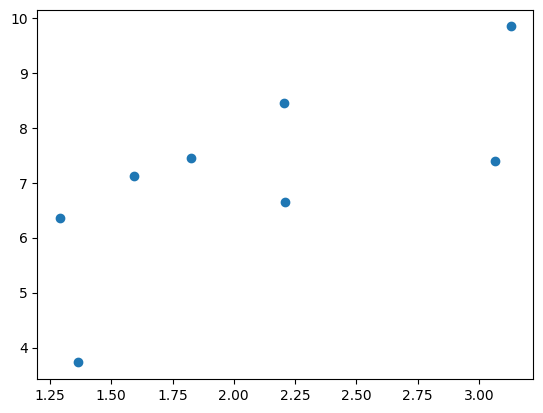

In [153]:
# 来看看产生x-y分布是什么样的
x, y = get_fake_data()
plt.scatter(x.squeeze().numpy(), y.squeeze().numpy())

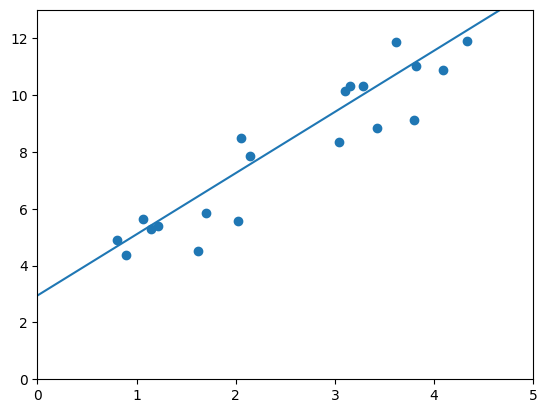

2.013629913330078 3.0284783840179443


In [157]:
# 随机初始化参数
w = t.rand(1,1, requires_grad=True)
b = t.zeros(1,1, requires_grad=True)
losses = np.zeros(500)

print(losses.shape)

lr =0.005 # 学习率

for ii in range(500):
    x, y = get_fake_data(batch_size=32)
    
    # forward：计算loss
    y_pred = x.mm(w) + b.expand_as(y)
    loss = 0.5 * (y_pred - y) ** 2
    loss = loss.sum()  # 每次都计算的是一个批次的loss，这里是把每一个进行了累加
    losses[ii] = loss.item()
    
    # backward：自动计算梯度
    loss.backward()
    
    # 更新参数
    w.data.sub_(lr * w.grad.data)
    b.data.sub_(lr * b.grad.data)
    
    # 梯度清零
    w.grad.data.zero_()
    b.grad.data.zero_()

    
    if ii%50 ==0:
        # 画图
        display.clear_output(wait=True)
        x = t.arange(0, 6).float().view(-1, 1)
        y = x.mm(w.data) + b.data.expand_as(x)
        plt.plot(x.numpy(), y.numpy()) # predicted
        
        x2, y2 = get_fake_data(batch_size=20) 
        plt.scatter(x2.numpy(), y2.numpy()) # true data
        
        plt.xlim(0,5)
        plt.ylim(0,13)   
        plt.show()
        plt.pause(0.5)
        
print(w.item(), b.item())

(5.0, 50.0)

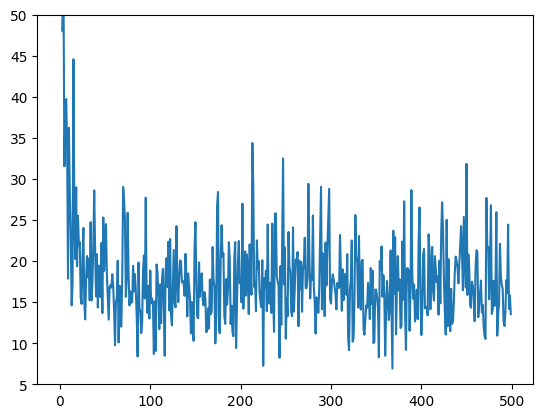

In [156]:
plt.plot(losses)
plt.ylim(5,50)

用autograd实现的线性回归最大的不同点就在于autograd不需要计算反向传播，可以自动计算微分。这点不单是在深度学习，在许多机器学习的问题中都很有用。另外需要注意的是在每次反向传播之前要记得先把梯度清零。

## 本章小结

本章主要介绍了PyTorch中的基础底层的数据结构Tensor和autograd方法。Tensor是一个类似Numpy数组的高效多维数值运算数据结构，有着和Numpy相类似的接口，并提供简单易用的GPU加速。`autograd`是PyTorch的自动微分引擎，采用动态计算图技术，能够快速高效的计算导数。